Load packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pypsa
import logging
from contextlib import redirect_stdout
from pathlib import Path
from typing import Sequence, Any
from types import MethodType
import tqdm
import matplotlib.dates as mdates

logger = logging.getLogger(__name__)
np.set_printoptions(suppress=True)


# Load used functions

In [5]:
# Load cost and data
def load_all_data():
    data = {
        "solar": pd.read_csv("Data/pv_optimal_NOR_ESP.csv", sep=";", index_col=0, parse_dates=True),
        "onwind": pd.read_csv("Data/onshore_wind_1979-2017_NOR_ESP.csv", sep=";", index_col=0, parse_dates=True),
        "offwind": pd.read_csv("Data/offshore_wind_1979-2017_NOR.csv", sep=";", index_col=0, parse_dates=True),
        "demand": pd.read_csv("Data/load_data_actual_NOR_ES.csv", sep=";", index_col=0, parse_dates=True)
    }

    # Rename demand columns to standard naming
    data["demand"] = data["demand"].rename(columns={
        "NO_load_actual_entsoe_transparency": "NOR",
        "ES_load_actual_entsoe_transparency": "ESP"
    })
    data["demand"] = data["demand"].ffill().bfill()

    # Load and convert hydro inflow data to hourly MW
    def convert_hydro_to_hourly(path, label):
        df = pd.read_csv(path)
        df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
        df = df[df['date'].dt.strftime('%m-%d') != '02-29']
        df['Hourly_MW'] = round(df['Inflow [GWh]'] * 1000 / 24)  # Convert GWh to MW and distribute evenly across 24 hours
        df_hourly = pd.DataFrame({
            'datetime': df['date'].repeat(24) + pd.to_timedelta(list(range(24)) * len(df), unit='h'),
            label: df['Hourly_MW'].repeat(24).values
        })
        df_hourly = df_hourly.set_index('datetime')
        return df_hourly

    es_hourly = convert_hydro_to_hourly("Data/Hydro_Inflow_ES.csv", 'ESP')
    no_hourly = convert_hydro_to_hourly("Data/Hydro_Inflow_NO.csv", 'NOR')

    hydro_inflow = pd.concat([es_hourly, no_hourly], axis=1)
    data["hydro_inflow"] = hydro_inflow

    return data

class CostGeneration:
    def __init__(self, year: int = 2020):
        self.year = year
        self.costs, self.units = self.cost_data()

    def cost_data(self):
        url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{self.year}.csv"
        df = pd.read_csv(url, index_col=[0, 1])

        df.loc[df.unit.str.contains("/kW"), "value"] *= 1e3
        df.unit = df.unit.str.replace("/kW", "/MW")

        # Save units before dropping
        unit_df = df["unit"].copy()
        
        defaults = {
            "FOM": 0,
            "VOM": 0,
            "efficiency": 1,
            "fuel": 0,
            "investment": 0,
            "lifetime": 25,
            "CO2 intensity": 0,
            "discount rate": 0.07,
        }

        costs = df.value.unstack().fillna(defaults)

        costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
        costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
        costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
        costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

        #costs.at["onwind", "VOM"] = 2.06
        #costs.at["offwind", "VOM"] = 4.41

        costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]
        annuity = costs.apply(lambda x: self.annuity(x["discount rate"], x["lifetime"]), axis=1)
        costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]


        return costs, unit_df

    @staticmethod
    def annuity(r, n):
        """ Calculate the annuity factor for an asset with lifetime n years and
        discount rate r """
        return r / (1.0 - 1.0 / (1.0 + r) ** n)

All_data = load_all_data()
Cost = CostGeneration(year=2025)

In [6]:
# Rolling horizon function edited to include total objective value
def optimize_with_rolling_horizon_collect(self, snapshots=None, horizon=100, overlap=0, **kwargs):
    """
    Custom rolling horizon optimization that collects objectives
    and stores them in n.attrs.
    """
    n = self  

    if snapshots is None:
        snapshots = n.snapshots

    if horizon <= overlap:
        raise ValueError("overlap must be smaller than horizon")

    objs, runs = [], []

    for i in range(0, len(snapshots), horizon - overlap):
        start = i
        end = min(len(snapshots), i + horizon)
        sns = snapshots[start:end]

        if i:
            if not n.stores.empty:
                n.stores.e_initial = n.stores_t.e.loc[snapshots[start - 1]]
            if not n.storage_units.empty:
                n.storage_units.state_of_charge_initial = (
                    n.storage_units_t.state_of_charge.loc[snapshots[start - 1]]
                )

        status, condition = n.optimize(sns, **kwargs)

        if status != "ok":
            logger.warning(
                "Optimization failed with status %s and condition %s",
                status, condition
            )

        if hasattr(n, "objective"):
            objs.append(n.objective)
            runs.append({"run": i + 1, "start": sns[0], "end": sns[-1]})

    # Store results in network attributes
    n.generators.attrs["rolling_objectives"] = objs
    n.generators.attrs["rolling_runs"] = runs

    return n


In [63]:
# Plotting functions
def plot_dispatch(network, colors=None, save_plots=False,
                  start_hour=0, duration_hours=7 * 24, interval=None,
                  title="Dispatch"):
    """
    Plot dispatch for a network.

    Parameters
    ----------
    network : pypsa.Network-like
    colors : dict or None
        mapping from component name -> matplotlib color
    save_plots : bool
    start_hour : int
        only used when `interval` is None (iloc-based slicing)
    duration_hours : int
        only used when `interval` is None (iloc-based slicing)
    interval : tuple (start, end) or None
        If provided, slices all time series with .loc[start:end] using
        the network time index. start/end can be pd.Timestamp, string, etc.
    title : str
    """
    import matplotlib.pyplot as plt

    # Determine slicing mode
    use_label_slice = interval is not None
    if use_label_slice:
        start, end = interval

    end_hour = start_hour + duration_hours

    plt.figure(figsize=(12, 5))

    # Plot generator dispatch
    for generator in network.generators.index:
        # only plot sizable optimized capacities (keeps behaviour similar to your original)
        p_nom_opt = network.generators.p_nom_opt.get(generator, 0)
        if p_nom_opt <= 10:
            continue

        series = network.generators_t.p[generator]

        if use_label_slice:
            series_slice = series.loc[start:end]
        else:
            series_slice = series.iloc[start_hour:end_hour]

        # defensive: skip empty slices
        if series_slice.empty:
            continue

        plt.plot(series_slice.index, series_slice.values,
                 label=generator,
                 color=(colors.get(generator) if colors else None))

    # Plot hydro dispatch (storage_units_t.p_dispatch)
    storage_units = network.storage_units
    hydro_mask = (storage_units.carrier == "hydro") & (storage_units.bus == "electricity bus")
    if hydro_mask.any():
        for idx in storage_units[hydro_mask].index:
            # some pypsa versions: storage_units_t.p_dispatch or storage_units_t.p
            # prefer p_dispatch if available
            if "p_dispatch" in getattr(network.storage_units_t, "columns", []):
                series = network.storage_units_t.p_dispatch[idx]
            else:
                # fallback if different naming
                series = network.storage_units_t.p[idx]

            if use_label_slice:
                series_slice = series.loc[start:end]
            else:
                series_slice = series.iloc[start_hour:end_hour]

            if series_slice.empty:
                continue

            plt.plot(series_slice.index, series_slice.values,
                     label=f"{idx} (hydro dispatch)",
                     color=(colors.get("hydro") if colors else "green"),
                     linestyle="--")

    # Plot load (if present)
    # loads_t.p_set is usually a DataFrame with columns being load names; we used "load"
    try:
        load_series = network.loads_t.p_set["load"]
    except Exception:
        # try the case where loads_t.p_set has a different structure
        # pick the first column if "load" not present
        if hasattr(network.loads_t.p_set, "columns") and len(network.loads_t.p_set.columns) > 0:
            load_series = network.loads_t.p_set.iloc[:, 0]
        else:
            load_series = None

    if load_series is not None:
        if use_label_slice:
            load_slice = load_series.loc[start:end]
        else:
            load_slice = load_series.iloc[start_hour:end_hour]

        if not load_slice.empty:
            plt.plot(load_slice.index, load_slice.values,
                     label="load", color="black", linestyle=":")

    # Formatting
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(f'{title}', y=1.07)
    plt.ylabel('Generation in MWh')
    plt.grid(True, which='major', alpha=0.25)
    plt.legend()
    if save_plots:
        # derive a simple filename from interval or start_hour
        if use_label_slice:
            s = str(start).replace(":", "-")
            e = str(end).replace(":", "-")
            fname = f'./Plots/dispatch_{s}_to_{e}.png'
        else:
            fname = f'./Plots/dispatch_{start_hour}_{end_hour}.png'
        plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()

def plot_hydro(network_pf, network_rh, interval=None, normalized=True, show_inflow=True, show_dispatch=True, show_soc=True, same_axes=False):
    # years
    year_pf = network_pf.snapshots[0].year
    year_rh = network_rh.snapshots[0].year

    # inflow source year -> remap to network years and align to snapshots
    inflow_src = All_data["hydro_inflow"][region]
    inflow_year = inflow_src[inflow_src.index.year == h_year_dispatch].copy()

    def align_inflow_to_network(inflow, net_year, snaps):
        s = inflow.copy()
        s.index = s.index.map(lambda t: t.replace(year=net_year))
        return s.reindex(snaps).interpolate(limit_direction="both")

    inflow_pf = network_pf.storage_units_t.inflow["Reservoir hydro storage"]
    inflow_rh = network_rh.storage_units_t.inflow["Reservoir hydro storage"]

    # dispatch & SOC
    disp_pf = network_pf.storage_units_t.p["Reservoir hydro storage"]
    soc_pf  = network_pf.storage_units_t.state_of_charge["Reservoir hydro storage"]
    disp_rh = network_rh.storage_units_t.p["Reservoir hydro storage"]
    soc_rh  = network_rh.storage_units_t.state_of_charge["Reservoir hydro storage"]

    # optional interval (use datetime strings or Timestamps)
    if interval is not None:
        start, end = interval
        inflow_pf = inflow_pf.loc[start:end];    disp_pf = disp_pf.loc[start:end];    soc_pf = soc_pf.loc[start:end]
        inflow_rh = inflow_rh.loc[start:end];    disp_rh = disp_rh.loc[start:end];    soc_rh = soc_rh.loc[start:end]

    # normalization helpers
    def safe_norm(s):
        m = float(s.max()) if len(s) else 0.0
        return s / m if m > 0 else s*0.0

    def soc_norm(s):
        denom = 12700 * 1300
        return s / denom if denom else s

    # choose data as normalized or raw
    disp_pf_plot = safe_norm(disp_pf) if normalized else disp_pf
    disp_rh_plot = safe_norm(disp_rh) if normalized else disp_rh
    inflow_pf_plot = safe_norm(inflow_pf) if normalized else inflow_pf
    inflow_rh_plot = safe_norm(inflow_rh) if normalized else inflow_rh
    soc_pf_plot  = soc_norm(soc_pf) if normalized else soc_pf
    soc_rh_plot  = soc_norm(soc_rh) if normalized else soc_rh

    # plotting
    if same_axes:
        fig, ax = plt.subplots(figsize=(12, 5))

        if show_dispatch:
            ax.plot(disp_pf_plot, label="Hydro Dispatch PF", color='#6baed6', linestyle='-')
            ax.plot(disp_rh_plot, label="Hydro Dispatch RH", color='#6baed6', linestyle='--')
        if show_inflow:
            ax.plot(inflow_pf_plot, label=f"Inflow PF (yr {h_year_dispatch})", color='tab:blue', linestyle='-')
            ax.plot(inflow_rh_plot, label=f"Inflow RH (yr {h_year_dispatch})", color='tab:blue', linestyle='--')
        if show_soc:
            ax.plot(soc_pf_plot, label="SOC PF", color='tab:green', linestyle='-')
            ax.plot(soc_rh_plot, label="SOC RH", color='tab:green', linestyle='--')

        ax.set_title(f"{'Normalized ' if normalized else ''}Hydro - PF vs RH - {region} ({year_pf} / {year_rh})")
        ax.set_ylabel("Normalized" if normalized else "MWh")
        ax.set_xlabel("Date")
        if normalized:
            ax.set_ylim(0, 1.1)
        ax.grid(True)
        ax.legend(loc='upper right')
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
        plt.xticks(rotation=30)
        plt.tight_layout()
        return fig, ax

    else:
        fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

        # RH (top)
        if show_dispatch: axes[0].plot(disp_rh_plot, label="Hydro Dispatch RH", color='#6baed6')
        if show_inflow:   axes[0].plot(inflow_rh_plot, label=f"Hydro Inflow RH (yr {h_year_dispatch})", color='tab:blue')
        if show_soc:      axes[0].plot(soc_rh_plot, label="State of Charge RH", color='tab:green')
        axes[0].set_title(f"{'Normalized ' if normalized else ''}Hydro - Rolling Horizon - {region} {year_rh}")
        axes[0].set_ylabel("Normalized" if normalized else "MWh")
        if normalized: axes[0].set_ylim(0, 1.1)
        axes[0].grid(True); axes[0].legend(loc='upper right')

        # PF (bottom)
        if show_dispatch: axes[1].plot(disp_pf_plot, label="Hydro Dispatch PF", color='#6baed6')
        if show_inflow:   axes[1].plot(inflow_pf_plot, label=f"Hydro Inflow PF (yr {h_year_dispatch})", color='tab:blue')
        if show_soc:      axes[1].plot(soc_pf_plot, label="State of Charge PF", color='tab:green')
        axes[1].set_title(f"{'Normalized ' if normalized else ''}Hydro - Perfect Foresight - {region} {year_pf}")
        axes[1].set_xlabel("Date"); axes[1].set_ylabel("Normalized" if normalized else "MWh")
        if normalized: axes[1].set_ylim(0, 1.1)
        axes[1].grid(True); axes[1].legend(loc='upper right')

        axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
        axes[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
        plt.xticks(rotation=30)
        plt.tight_layout()
        return fig, axes

def plot_marginal_prices(network_pf, network_rh, month=None, interval=None):
    # Extract marginal prices (first bus column)
    mc_pf = network_pf.buses_t['marginal_price'].iloc[:, 0]
    mc_rh = network_rh.buses_t['marginal_price'].iloc[:, 0]

    # Apply month filter
    if month is not None:
        mc_pf = mc_pf[mc_pf.index.month == month]
        mc_rh = mc_rh[mc_rh.index.month == month]

    # Apply interval filter
    if interval is not None:
        start, end = interval
        mc_pf = mc_pf.loc[start:end]
        mc_rh = mc_rh.loc[start:end]

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(mc_pf, label="Marginal prices PF", linestyle="--")
    plt.plot(mc_rh, label="Marginal prices RH", linestyle=":")
    plt.xlabel("Time")
    plt.ylabel("Marginal Price [EUR/MWh]")
    plt.title("Marginal Prices Comparison PF vs RH")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Cost calculations
    cost_pf = (network_pf.buses_t['marginal_price'].iloc[:, 0] * 
               network_pf.loads_t.p_set['load']).sum() / 1e6
    cost_rh = (network_rh.buses_t['marginal_price'].iloc[:, 0] * 
               network_rh.loads_t.p_set['load']).sum() / 1e6

    print(f"Sum of marginal prices (PF): {mc_pf.sum():.1f}")
    print(f"Sum of marginal prices (RH): {mc_rh.sum():.1f}")
    print(f"Total cost (PF) [MEUR]: {cost_pf:.2f}")
    print(f"Total cost (RH) [MEUR]: {cost_rh:.2f}")
    print(f"Total cost difference PF minus RH [MEUR]: {cost_rh - cost_pf:.2f}")



In [8]:
# Other functions
def tot_cost_N(N):
    return (N.buses_t['marginal_price'].iloc[:, 0] * 
               N.loads_t.p_set['load']).sum() 

def silent_optimize(network, solver_name="gurobi", solver_options=None):
    """
    Optimize a PyPSA network silently: suppress logs, progress bars, and Gurobi messages.
    
    Parameters:
    - network: PyPSA Network object
    - solver_name: Solver name (default: "gurobi")
    - solver_options: Dictionary of solver options (default: {"OutputFlag": 0})
    """
    if solver_options is None:
        solver_options = {"OutputFlag": 0}

    # Suppress PyPSA, Linopy, Gurobi logging output
    for name in ["pypsa", "linopy", "gurobipy"]:
        logging.getLogger(name).setLevel(logging.CRITICAL)

    # Monkey-patch tqdm to disable progress bars
    tqdm.tqdm = lambda *args, **kwargs: iter(args[0]) if args else iter([])

    # Redirect stdout to suppress Gurobi messages
    with open(os.devnull, 'w') as fnull:
        with redirect_stdout(fnull):
            network.optimize(solver_name=solver_name, assign_all_duals=True, solver_options=solver_options)
            #print("Objective value:", network.objective)

def unique_prices(network):
    prices = network.buses_t.marginal_price["electricity bus"].unique().round(1)
    return sorted(float(p) for p in prices)


# Load dispatch model

In [9]:
class Build_dispatch_network:
    def __init__(
        self,
        opt_capacities_df: pd.DataFrame,
        weather_year: int = 2011,
        hydro_year: int = 2011,
        demand_year: int = 2018,
        data: dict = None,
        cost_data: tuple = None,
        setup: dict = None
    ):
        if setup is None:
            setup = {
                'NOR': {
                    'OCGT': True,
                    'CCGT': False,
                    'battery storage': True,
                    'onwind': True,
                    'offwind': False,
                    'solar': True,
                    'electrolysis': True,
                    'fuel cell': True,
                    'Hydrogen storage': True,
                    'Reservoir hydro storage': True,
                    'load shedding': True
                }
            }

        self.weather_year = weather_year
        self.hydro_year = hydro_year
        self.demand_year = demand_year
        self.setup = setup
        self.region = list(setup.keys())[0]

        self.costs = cost_data.costs
        self.cost_units = cost_data.units

        self.opt_caps = opt_capacities_df

        self.all_data = data if data is not None else load_all_data()
        self.data_dict = {self.region: self.extract_data(self.region, self.weather_year, self.hydro_year, self.demand_year)}

        self.network = pypsa.Network()
        self.hours_in_year = pd.date_range(f'{weather_year}-01-01 00:00', f'{weather_year}-12-31 23:00', freq='h')
        if len(self.hours_in_year) > 8760:
            self.hours_in_year = self.hours_in_year[self.hours_in_year.strftime('%m-%d') != '02-29']
        self.network.set_snapshots(self.hours_in_year.values)

        self.carriers = ['gas', 'onwind', 'offwind', 'solar', 'battery charge', 'battery discharge', 'electrolysis', 'fuel cell', 'hydrogen', 'hydro', 'load shedding']

        self.colors = {
            'gas': 'gray', 'onwind': 'lightblue', 'offwind': 'dodgerblue', 'solar': 'orange',
            'battery charge': 'gold', 'battery discharge': 'darkorange', 'electrolysis': 'green',
            'fuel cell': 'limegreen', 'hydrogen': 'deepskyblue', 'hydro': 'slateblue', 'load shedding': 'red'
        }

        self.network.add("Carrier", self.carriers, color=[self.colors[c] for c in self.carriers],
                         co2_emissions=[self.costs.at[c, "CO2 intensity"] if c in self.costs.index else 0.0 for c in self.carriers])

        self.network.add("Bus", 'electricity bus')
        self.network.add("Bus", 'hydrogen bus')
        self.network.add("Load", 'load', bus='electricity bus', p_set=self.data_dict[self.region]['demand'].values.flatten())


        for tech, active in self.setup[self.region].items():
            if not active:
                continue

            if tech in ['OCGT', 'CCGT', 'onwind', 'offwind', 'solar']:
                self.network.add("Generator", tech,
                    bus='electricity bus',
                    p_nom=self.opt_caps.at["generators", tech],
                    p_nom_extendable=False,
                    carrier=tech if tech in ['solar', 'onwind', 'offwind'] else 'gas',
                    capital_cost=0,
                    marginal_cost=self.costs.at[tech, "marginal_cost"],
                    p_max_pu=self.data_dict[self.region][tech].values.flatten() if tech != 'OCGT' else None)

            elif tech == 'load shedding':
                # Add load shedding generator
                self.network.add("Generator", tech,
                    bus="electricity bus",
                    p_nom_extendable=True,
                    marginal_cost=2000,
                    capital_cost=0,
                    carrier="load shedding")

            elif tech == 'battery storage':
                self.network.add("Bus", 'battery bus')
                self.network.add("Link", 'battery charge',
                    bus0='electricity bus', bus1='battery bus',
                    carrier='battery charge',
                    p_nom=self.opt_caps.at['links', 'battery charge'],
                    p_nom_extendable=False,
                    capital_cost=0,
                    efficiency=self.costs.at['battery inverter', 'efficiency'])
                
                self.network.add("Link", 'battery discharge',
                    bus0='battery bus', bus1='electricity bus',
                    carrier='battery discharge',
                    p_nom=self.opt_caps.at['links', 'battery discharge'],
                    p_nom_extendable=False,
                    capital_cost=0,
                    efficiency=self.costs.at['battery inverter', 'efficiency'])
                
                self.network.add("Store", tech,
                    bus='battery bus',
                    e_nom=self.opt_caps.at['stores', 'battery storage'],
                    e_nom_extendable=False,
                    e_cyclic=False,
                    capital_cost=0)

            elif tech == 'electrolysis':
                self.network.add("Link", tech,
                    bus0='electricity bus', bus1='hydrogen bus',
                    carrier='electrolysis',
                    p_nom=self.opt_caps.at['links', tech],
                    p_nom_extendable=False,
                    capital_cost=0,
                    efficiency=self.costs.at[tech, 'efficiency'])

            elif tech == 'fuel cell':
                self.network.add("Link", tech,
                    bus0='hydrogen bus', bus1='electricity bus',
                    carrier='fuel cell',
                    p_nom=self.opt_caps.at['links', tech],
                    p_nom_extendable=False,
                    capital_cost=0,
                    efficiency=self.costs.at[tech, 'efficiency'])

            elif tech == 'Hydrogen storage':
                self.network.add("Store", tech,
                    bus='hydrogen bus',
                    e_nom=self.opt_caps.at['stores', tech],
                    e_nom_extendable=False,
                    e_cyclic=False,
                    capital_cost=0,
                    carrier='hydrogen storage')

            elif tech == 'Reservoir hydro storage':
                self.network.add("StorageUnit", tech,
                    bus='electricity bus',
                    carrier='hydro',
                    p_nom=12700,
                    p_nom_extendable=False,
                    max_hours=1300,
                    efficiency_store=0,
                    efficiency_dispatch=self.costs.at['Pumped-Storage-Hydro-bicharger', 'efficiency'],
                    cyclic_state_of_charge=False,
                    inflow=self.data_dict[self.region]['hydro'].values.flatten(),
                    state_of_charge_initial= (12700 * 1300)*0.3 ,  # Initial storage capacity in MWh
                    marginal_cost=self.costs.at["OCGT", "marginal_cost"]*0.50,  
                    spill_cost = 100,
                    capital_cost=0)
    
    def extract_data(self, region: str, weather_year: int, hydro_year: int, demand_year: int):
        extracted = {}
        if demand_year not in self.all_data["demand"].index.year:
            print(f"Demand year {demand_year} not in data. Using 2017 instead.")
            demand_year = 2017
        if weather_year not in self.all_data["solar"].index.year:
            print(f"Weather year {weather_year} not in data. Using 2012 instead.")
            weather_year = 2012
        if hydro_year not in self.all_data["hydro_inflow"].index.year:
            print(f"Hydro year {hydro_year} not in data. Using 2011 instead.")
            hydro_year = 2011

        if region in self.all_data["demand"].columns:
            demand_series = self.all_data["demand"].loc[self.all_data["demand"].index.year == demand_year, region]
            extracted["demand"] = demand_series[demand_series.index.strftime('%m-%d') != '02-29'][:8760]

        for carrier in ["solar", "onwind", "offwind"]:
            if region in self.all_data[carrier].columns:
                weather_series = self.all_data[carrier].loc[self.all_data[carrier].index.year == weather_year, region]
                extracted[carrier] = weather_series[weather_series.index.strftime('%m-%d') != '02-29'][:8760]

        if region in self.all_data["hydro_inflow"].columns:
            hydro_series = self.all_data["hydro_inflow"].loc[self.all_data["hydro_inflow"].index.year == hydro_year, region]
            extracted["hydro"] = hydro_series[hydro_series.index.strftime('%m-%d') != '02-29'][:8760]

        return extracted    

# Running the model

In [65]:
region = 'ESP'  

# Default weather, hydro and demand years
w_year_exp = 2011
h_year_exp = 2007
d_year_exp = 2018

# Dispatch and rolling horizon settings
w_year_dispatch = 2017
h_year_dispatch = 2007
d_year_dispatch = 2019

weather_years = All_data['solar'].index.year.unique()

base_dir = os.getcwd()  # Gets the current working directory (where notebook is running)
N_results_path = os.path.join(base_dir, "Network_results")
Results_path = os.path.join(base_dir, "Results")

# Load optimal capacities from CSV
Name = f"optimized_capacities_exp_model_d{d_year_exp}_h{h_year_exp}_hMC.csv"
opt_capacities_df = pd.read_csv(os.path.join(Results_path, Name), header=[0,1], index_col=0)

## Example 1 with gas, solar, wind and hydro

In [66]:
# Define the use technologies and regions(s)
setup_dispatch = {
    f'{region}': {
        'OCGT': True,
        'CCGT': False,
        'battery storage': False,
        'onwind': True,
        'offwind': False,
        'solar': True,
        'electrolysis': False,
        'fuel cell': False,
        'Hydrogen storage': False,
        'Reservoir hydro storage': True,
        'load shedding': True
    }
}

test_year = 1996

d_horizon = 7 # days in horizon
o_horizon = 0 # days of overlap in rh

N_pf_class = Build_dispatch_network(
    opt_capacities_df=opt_capacities_df.loc["75%"],
    weather_year=test_year, hydro_year=h_year_dispatch, demand_year=d_year_dispatch,
    data=All_data, cost_data=Cost, setup=setup_dispatch
)
N_pf = N_pf_class.network
silent_optimize(N_pf)

N_rlh_class = Build_dispatch_network(
    opt_capacities_df=opt_capacities_df.loc["75%"],
    weather_year=test_year, hydro_year=h_year_dispatch, demand_year=d_year_dispatch,
    data=All_data, cost_data=Cost, setup=setup_dispatch
)
N_rlh = N_rlh_class.network

# Patch rolling horizon function onto the Network
N_rlh.optimize_with_rolling_horizon = MethodType(optimize_with_rolling_horizon_collect, N_rlh)

# Run the rolling-horizon optimization
N_rlh.optimize_with_rolling_horizon(
    snapshots=N_rlh.snapshots,
    horizon= 24 * d_horizon,
    overlap= 24 * o_horizon,
    solver_name="gurobi",
    solver_options={"OutputFlag": 0},
    assign_all_duals=True
)

c:\Users\jonat\miniforge3\envs\master-thesis-env\Lib\site-packages\pypsa\network\io.py:1700: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 32.64it/s]
c:\Users\jonat\miniforge3\envs\master-thesis-env\Lib\site-packages\pypsa\network\io.py:1700: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-8fhaothv.lp
Reading time = 0.00 seconds
obj: 2689 rows, 1345 columns, 4200 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-swaksvip.lp
Reading time = 0.01 seconds
obj: 2689 rows, 1345 columns, 4200 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-ngraa79d.lp
Reading time = 0.01 seconds
obj: 2689 rows, 1345 columns, 4200 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-pvxgr4dp.lp
Reading time = 0.00 seconds
obj: 2689 rows, 1345 col

PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 2
 - Carrier: 11
 - Generator: 4
 - Load: 1
 - StorageUnit: 1
Snapshots: 8760

In [67]:
print(f"Results for year {test_year} w hydro_year {h_year_dispatch} and demand_year {d_year_dispatch}")
print()
print("Objective PF:", N_pf.objective)
print("Objective RH:", sum(N_rlh.generators.attrs["rolling_objectives"]))
print("Difference RH - PF:", sum(N_rlh.generators.attrs["rolling_objectives"]) - N_pf.objective)
print("Is RH objective higher than PF objective?", sum(N_rlh.generators.attrs["rolling_objectives"]) > N_pf.objective)
print()
print("PF total cost [MEUR]:", round(tot_cost_N(N_pf)/1e6, 2))
print("RH total cost [MEUR]:", round(tot_cost_N(N_rlh)/1e6, 2))
print("Difference RH - PF total cost [MEUR]:", round((tot_cost_N(N_rlh) - tot_cost_N(N_pf))/1e6, 2))
print()
print("unique prices perfect foresight: ", unique_prices(N_pf))
print("unique prices rolling horizon:   ", unique_prices(N_rlh))

Results for year 1996 w hydro_year 2007 and demand_year 2019

Objective PF: 4145761166.8907437
Objective RH: 4145761166.890784
Difference RH - PF: 4.00543212890625e-05
Is RH objective higher than PF objective? True

PF total cost [MEUR]: 11837.02
RH total cost [MEUR]: 11060.75
Difference RH - PF total cost [MEUR]: -776.27

unique prices perfect foresight:  [1.5, 65.4]
unique prices rolling horizon:    [1.5, 32.7, 65.4]


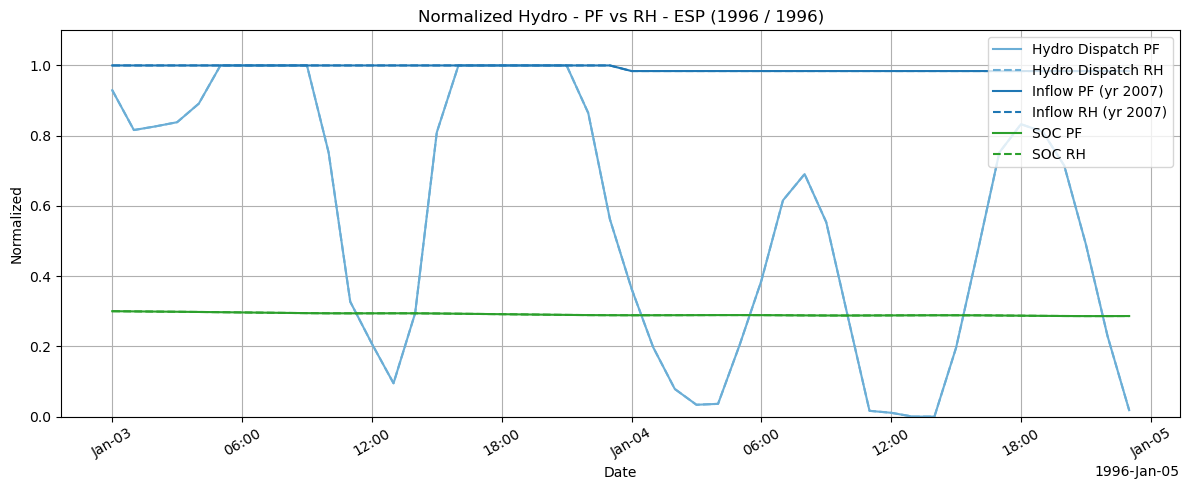

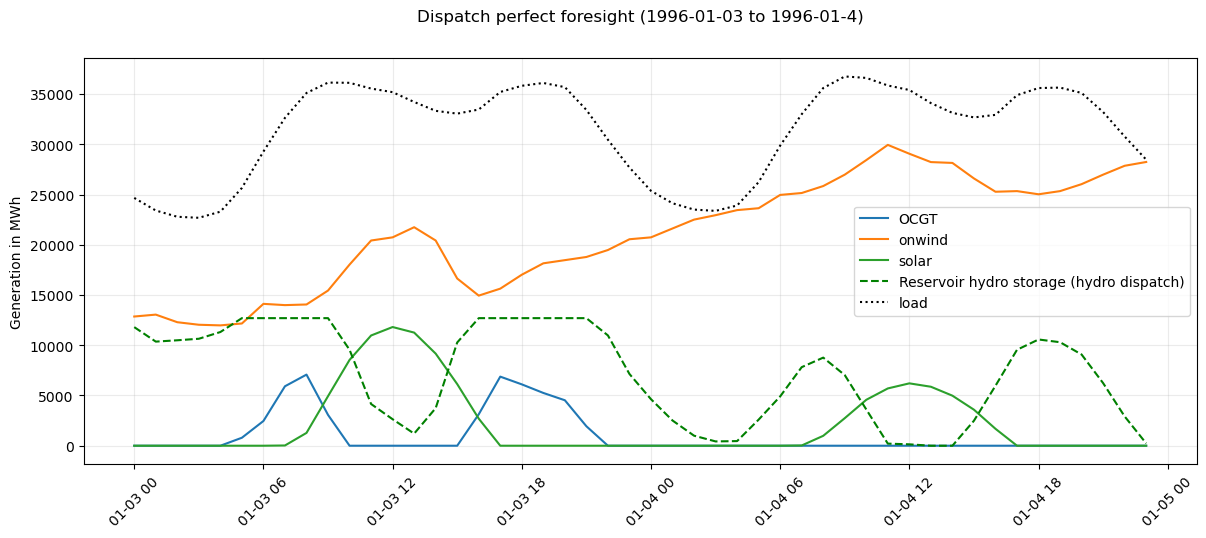

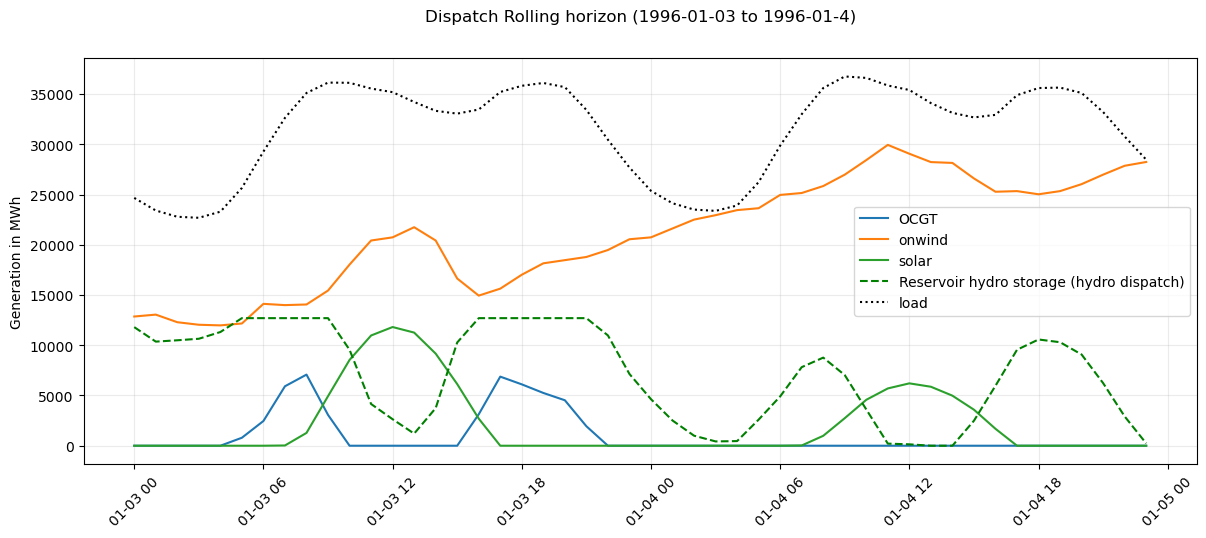

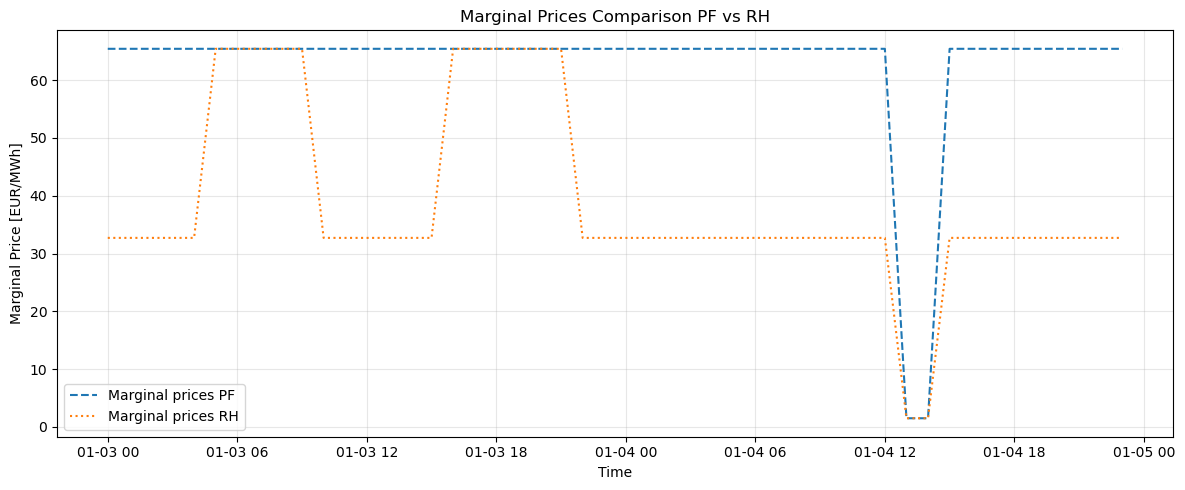

Sum of marginal prices (PF): 3012.5
Sum of marginal prices (RH): 1867.6
Total cost (PF) [MEUR]: 11837.02
Total cost (RH) [MEUR]: 11060.75
Total cost difference PF minus RH [MEUR]: -776.27


In [68]:
intervall = (f"{test_year}-01-03", f"{test_year}-01-4")
plot_hydro(N_rlh, N_pf, same_axes=True, show_soc=True, show_dispatch=True, 
        show_inflow = True, normalized = True, interval=intervall)
plot_dispatch(N_pf, interval=intervall, save_plots=False,
               title=f"Dispatch perfect foresight ({intervall[0]} to {intervall[1]})")
plot_dispatch(N_rlh, interval=intervall, save_plots=False,
               title=f"Dispatch Rolling horizon ({intervall[0]} to {intervall[1]})")
# Plot marginal prices and print cost comparison
plot_marginal_prices(N_pf, N_rlh, interval=intervall)


In [69]:
# To check wether there is minimal gas dispatch in the off hours
s = slice(*intervall) if intervall is not None else slice(None)
gas = N_pf.generators.index[N_pf.generators["carrier"] == "gas"]
dispatch_by_gas_ex1 = {g: N_pf.generators_t.p[g].loc[s] for g in gas if g in N_pf.generators_t.p}
dispatch_by_gas_ex1


{'OCGT': snapshot
 1996-01-03 00:00:00       0.000000
 1996-01-03 01:00:00       0.000000
 1996-01-03 02:00:00       0.000000
 1996-01-03 03:00:00       0.000000
 1996-01-03 04:00:00       0.000000
 1996-01-03 05:00:00     794.557978
 1996-01-03 06:00:00    2462.041384
 1996-01-03 07:00:00    5918.075721
 1996-01-03 08:00:00    7078.724416
 1996-01-03 09:00:00    3068.995005
 1996-01-03 10:00:00       0.000000
 1996-01-03 11:00:00       0.000000
 1996-01-03 12:00:00       0.000000
 1996-01-03 13:00:00       0.000000
 1996-01-03 14:00:00       0.000000
 1996-01-03 15:00:00       0.000000
 1996-01-03 16:00:00    3129.292569
 1996-01-03 17:00:00    6877.867246
 1996-01-03 18:00:00    6107.790954
 1996-01-03 19:00:00    5252.910351
 1996-01-03 20:00:00    4525.665739
 1996-01-03 21:00:00    1937.421127
 1996-01-03 22:00:00       0.000000
 1996-01-03 23:00:00       0.000000
 1996-01-04 00:00:00       0.000000
 1996-01-04 01:00:00       0.000000
 1996-01-04 02:00:00       0.000000
 1996-01-0

## Example 2 with gas, solar, hydro (no wind)

In [79]:
setup_dispatch = {
    f'{region}': {
        'OCGT': True,
        'CCGT': False,
        'battery storage': False,
        'onwind': False,
        'offwind': False,
        'solar': True,
        'electrolysis': False,
        'fuel cell': False,
        'Hydrogen storage': False,
        'Reservoir hydro storage': True,
        'load shedding': True
    }
}

test_year = 1996

d_horizon = 7 # days in horizon
o_horizon = 0 # days of overlap in rh

N_pf_class = Build_dispatch_network(
    opt_capacities_df=opt_capacities_df.loc["75%"],
    weather_year=test_year, hydro_year=h_year_dispatch, demand_year=d_year_dispatch,
    data=All_data, cost_data=Cost, setup=setup_dispatch
)
N_pf = N_pf_class.network
silent_optimize(N_pf)

N_rlh_class = Build_dispatch_network(
    opt_capacities_df=opt_capacities_df.loc["75%"],
    weather_year=test_year, hydro_year=h_year_dispatch, demand_year=d_year_dispatch,
    data=All_data, cost_data=Cost, setup=setup_dispatch
)
N_rlh = N_rlh_class.network

# Patch rolling horizon function onto the Network
N_rlh.optimize_with_rolling_horizon = MethodType(optimize_with_rolling_horizon_collect, N_rlh)

# Run the rolling-horizon optimization
N_rlh.optimize_with_rolling_horizon(
    snapshots=N_rlh.snapshots,
    horizon= 24 * d_horizon,
    overlap= 24 * o_horizon,
    solver_name="gurobi",
    solver_options={"OutputFlag": 0},
    assign_all_duals=True
)

c:\Users\jonat\miniforge3\envs\master-thesis-env\Lib\site-packages\pypsa\network\io.py:1700: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 37.25it/s]
c:\Users\jonat\miniforge3\envs\master-thesis-env\Lib\site-packages\pypsa\network\io.py:1700: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-eclz00bn.lp
Reading time = 0.02 seconds
obj: 2353 rows, 1177 columns, 3696 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-0f1x8kal.lp
Reading time = 0.02 seconds
obj: 2353 rows, 1177 columns, 3696 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-8tw3xxlf.lp
Reading time = 0.02 seconds
obj: 2353 rows, 1177 columns, 3696 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-7mf0jfkf.lp
Reading time = 0.01 seconds
obj: 2353 rows, 1177 col

PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 2
 - Carrier: 11
 - Generator: 3
 - Load: 1
 - StorageUnit: 1
Snapshots: 8760

In [71]:
print(f"Results for year {test_year} w hydro_year {h_year_dispatch} and demand_year {d_year_dispatch}")
print()
print("Objective PF:", N_pf.objective)
print("Objective RH:", sum(N_rlh.generators.attrs["rolling_objectives"]))
print("Difference RH - PF:", sum(N_rlh.generators.attrs["rolling_objectives"]) - N_pf.objective)
print("Is RH objective higher than PF objective?", sum(N_rlh.generators.attrs["rolling_objectives"]) > N_pf.objective)
print()
print("PF total cost [MEUR]:", round(tot_cost_N(N_pf)/1e6, 2))
print("RH total cost [MEUR]:", round(tot_cost_N(N_rlh)/1e6, 2))
print("Difference RH - PF total cost [MEUR]:", round((tot_cost_N(N_rlh) - tot_cost_N(N_pf))/1e6, 2))
print()
print("unique prices perfect foresight: ", unique_prices(N_pf))
print("unique prices rolling horizon:   ", unique_prices(N_rlh))

Results for year 1996 w hydro_year 2007 and demand_year 2019

Objective PF: 28363427879.764557
Objective RH: 42550352950.56007
Difference RH - PF: 14186925070.79551
Is RH objective higher than PF objective? True

PF total cost [MEUR]: 361380.86
RH total cost [MEUR]: 261771.58
Difference RH - PF total cost [MEUR]: -99609.28

unique prices perfect foresight:  [65.4, 2000.0]
unique prices rolling horizon:    [65.4, 2000.0]


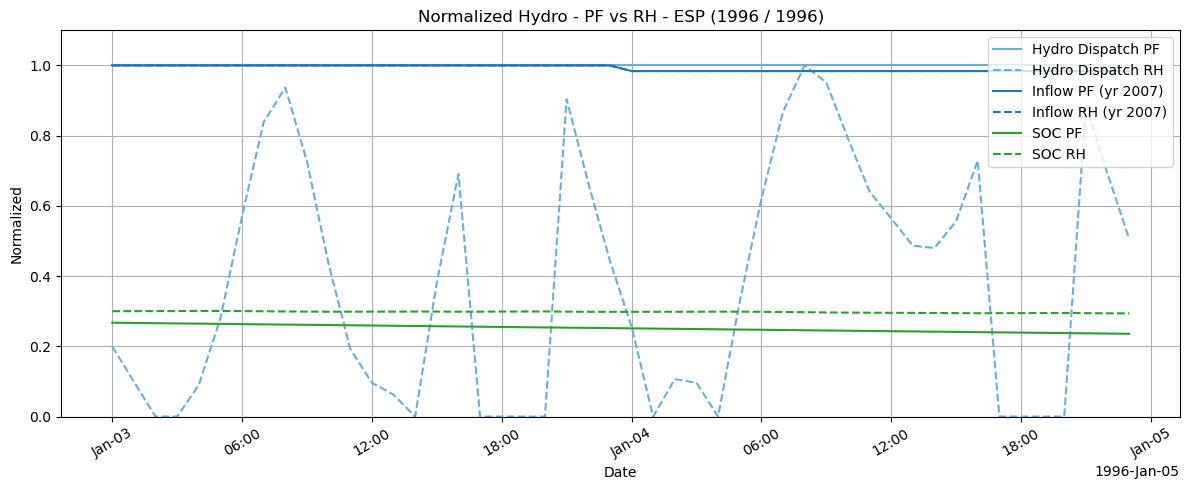

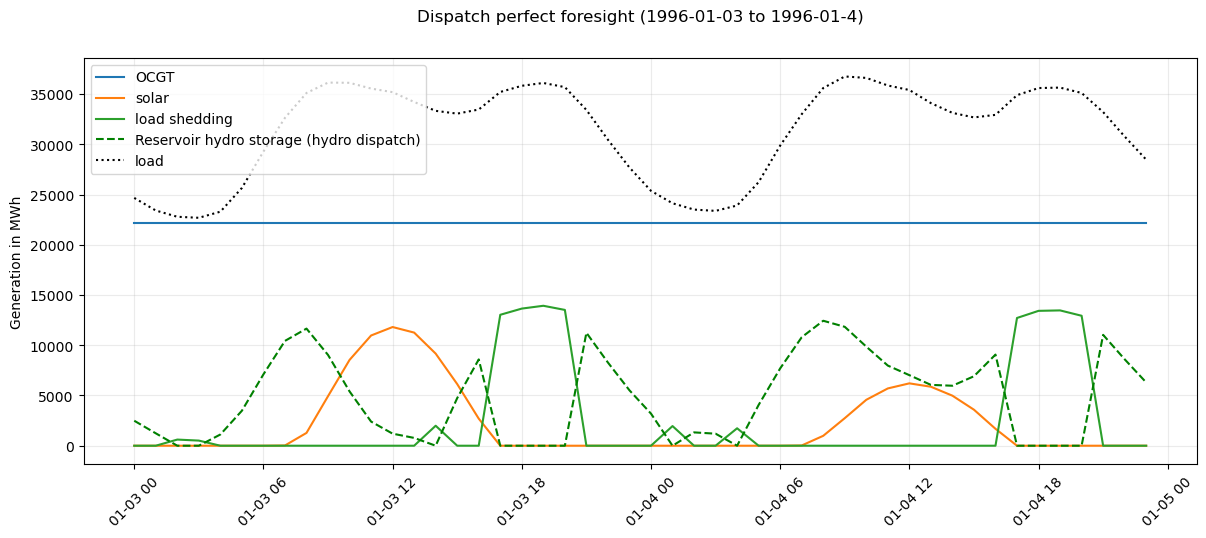

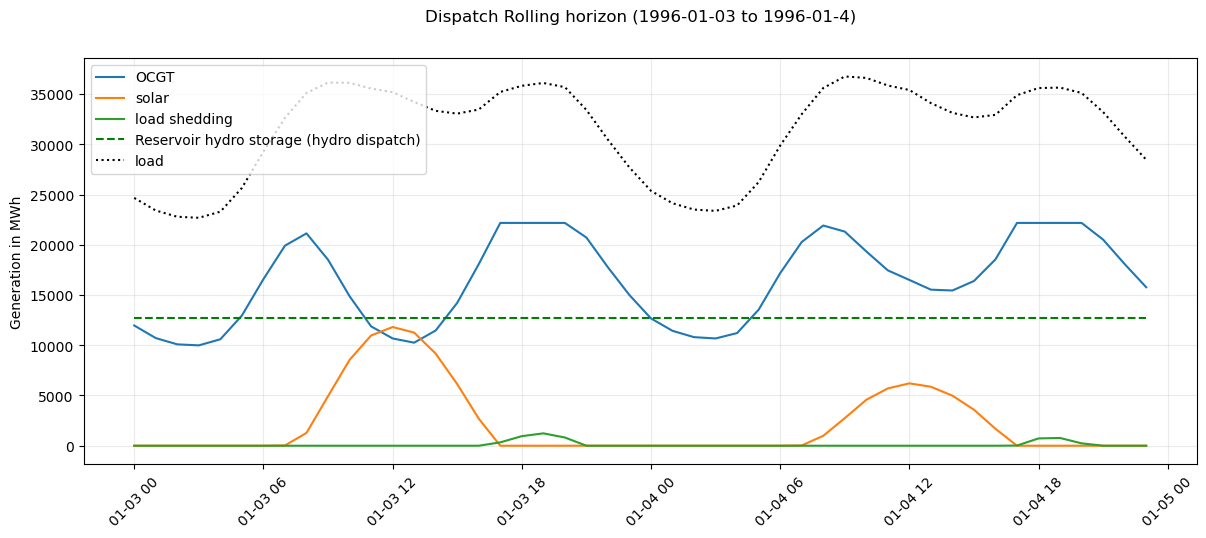

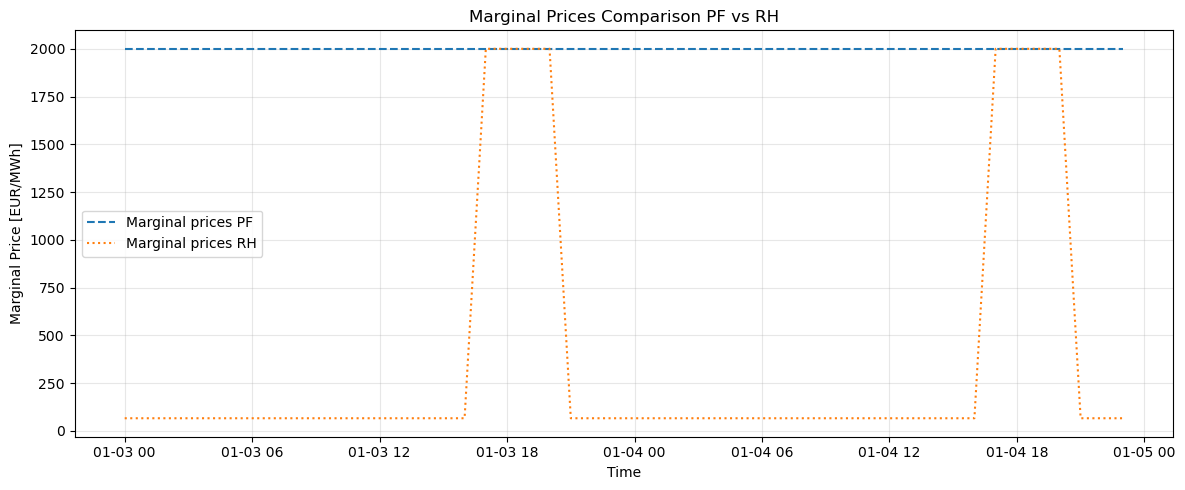

Sum of marginal prices (PF): 96000.0
Sum of marginal prices (RH): 18616.9
Total cost (PF) [MEUR]: 361380.86
Total cost (RH) [MEUR]: 261771.58
Total cost difference PF minus RH [MEUR]: -99609.28


In [72]:
intervall = (f"{test_year}-01-03", f"{test_year}-01-4")
plot_hydro(N_rlh, N_pf, same_axes=True, show_soc=True, show_dispatch=True, 
        show_inflow = True, normalized = True, interval=intervall)
plot_dispatch(N_pf, interval=intervall, save_plots=False,
               title=f"Dispatch perfect foresight ({intervall[0]} to {intervall[1]})")
plot_dispatch(N_rlh, interval=intervall, save_plots=False,
               title=f"Dispatch Rolling horizon ({intervall[0]} to {intervall[1]})")
# Plot marginal prices and print cost comparison
plot_marginal_prices(N_pf, N_rlh, interval=intervall)


In [80]:
# To check wether there is minimal load shedding dispatch in the off hours
s = slice(*intervall) if intervall is not None else slice(None)
load_shedding = N_pf.generators.index[N_pf.generators["carrier"] == "load shedding"]
dispatch_by_load_shedding_ex2 = {g: N_pf.generators_t.p[g].loc[s] for g in load_shedding if g in N_pf.generators_t.p}
dispatch_by_load_shedding_ex2


{'load shedding': snapshot
 1996-01-03 00:00:00        0.000000
 1996-01-03 01:00:00        0.000000
 1996-01-03 02:00:00      611.362446
 1996-01-03 03:00:00      510.362446
 1996-01-03 04:00:00        0.000000
 1996-01-03 05:00:00        0.000000
 1996-01-03 06:00:00        0.000000
 1996-01-03 07:00:00        0.000000
 1996-01-03 08:00:00        0.000000
 1996-01-03 09:00:00        0.000000
 1996-01-03 10:00:00        0.000000
 1996-01-03 11:00:00        0.000000
 1996-01-03 12:00:00        0.000000
 1996-01-03 13:00:00        0.000000
 1996-01-03 14:00:00     1989.166144
 1996-01-03 15:00:00        0.000000
 1996-01-03 16:00:00        0.000000
 1996-01-03 17:00:00    13034.362446
 1996-01-03 18:00:00    13651.362446
 1996-01-03 19:00:00    13931.362446
 1996-01-03 20:00:00    13519.362446
 1996-01-03 21:00:00        0.000000
 1996-01-03 22:00:00        0.000000
 1996-01-03 23:00:00        0.000000
 1996-01-04 00:00:00        0.000000
 1996-01-04 01:00:00     1956.362446
 1996-01-04

## Example 3 with only gas and hydro (no solar, no wind) - and a lot of load shedding

In [74]:
setup_dispatch = {
    f'{region}': {
        'OCGT': True,
        'CCGT': False,
        'battery storage': False,
        'onwind': False,
        'offwind': False,
        'solar': False,
        'electrolysis': False,
        'fuel cell': False,
        'Hydrogen storage': False,
        'Reservoir hydro storage': True,
        'load shedding': True
    }
}

test_year = 1996

d_horizon = 7 # days in horizon
o_horizon = 0 # days of overlap in rh

N_pf_class = Build_dispatch_network(
    opt_capacities_df=opt_capacities_df.loc["75%"],
    weather_year=test_year, hydro_year=h_year_dispatch, demand_year=d_year_dispatch,
    data=All_data, cost_data=Cost, setup=setup_dispatch
)
N_pf = N_pf_class.network
silent_optimize(N_pf)

N_rlh_class = Build_dispatch_network(
    opt_capacities_df=opt_capacities_df.loc["75%"],
    weather_year=test_year, hydro_year=h_year_dispatch, demand_year=d_year_dispatch,
    data=All_data, cost_data=Cost, setup=setup_dispatch
)
N_rlh = N_rlh_class.network

# Patch rolling horizon function onto the Network
N_rlh.optimize_with_rolling_horizon = MethodType(optimize_with_rolling_horizon_collect, N_rlh)

# Run the rolling-horizon optimization
N_rlh.optimize_with_rolling_horizon(
    snapshots=N_rlh.snapshots,
    horizon= 24 * d_horizon,
    overlap= 24 * o_horizon,
    solver_name="gurobi",
    solver_options={"OutputFlag": 0},
    assign_all_duals=True
)

c:\Users\jonat\miniforge3\envs\master-thesis-env\Lib\site-packages\pypsa\network\io.py:1700: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 36.87it/s]
c:\Users\jonat\miniforge3\envs\master-thesis-env\Lib\site-packages\pypsa\network\io.py:1700: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-h3xs4qvi.lp
Reading time = 0.01 seconds
obj: 2017 rows, 1009 columns, 3192 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-2uy2wy9s.lp
Reading time = 0.01 seconds
obj: 2017 rows, 1009 columns, 3192 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-oxe664v6.lp
Reading time = 0.00 seconds
obj: 2017 rows, 1009 columns, 3192 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-wwfh3ybw.lp
Reading time = 0.01 seconds
obj: 2017 rows, 1009 col

PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 2
 - Carrier: 11
 - Generator: 2
 - Load: 1
 - StorageUnit: 1
Snapshots: 8760

In [75]:
print(f"Results for year {test_year} w hydro_year {h_year_dispatch} and demand_year {d_year_dispatch}")
print()
print("Objective PF:", N_pf.objective)
print("Objective RH:", sum(N_rlh.generators.attrs["rolling_objectives"]))
print("Difference RH - PF:", sum(N_rlh.generators.attrs["rolling_objectives"]) - N_pf.objective)
print("Is RH objective higher than PF objective?", sum(N_rlh.generators.attrs["rolling_objectives"]) > N_pf.objective)
print()
print("PF total cost [MEUR]:", round(tot_cost_N(N_pf)/1e6, 2))
print("RH total cost [MEUR]:", round(tot_cost_N(N_rlh)/1e6, 2))
print("Difference RH - PF total cost [MEUR]:", round((tot_cost_N(N_rlh) - tot_cost_N(N_pf))/1e6, 2))
print()
print("unique prices perfect foresight: ", unique_prices(N_pf))
print("unique prices rolling horizon:   ", unique_prices(N_rlh))

Results for year 1996 w hydro_year 2007 and demand_year 2019

Objective PF: 78554392530.29993
Objective RH: 83795553665.01985
Difference RH - PF: 5241161134.719925
Is RH objective higher than PF objective? True

PF total cost [MEUR]: 473206.17
RH total cost [MEUR]: 432173.76
Difference RH - PF total cost [MEUR]: -41032.41

unique prices perfect foresight:  [65.4, 2000.0]
unique prices rolling horizon:    [65.4, 2000.0]


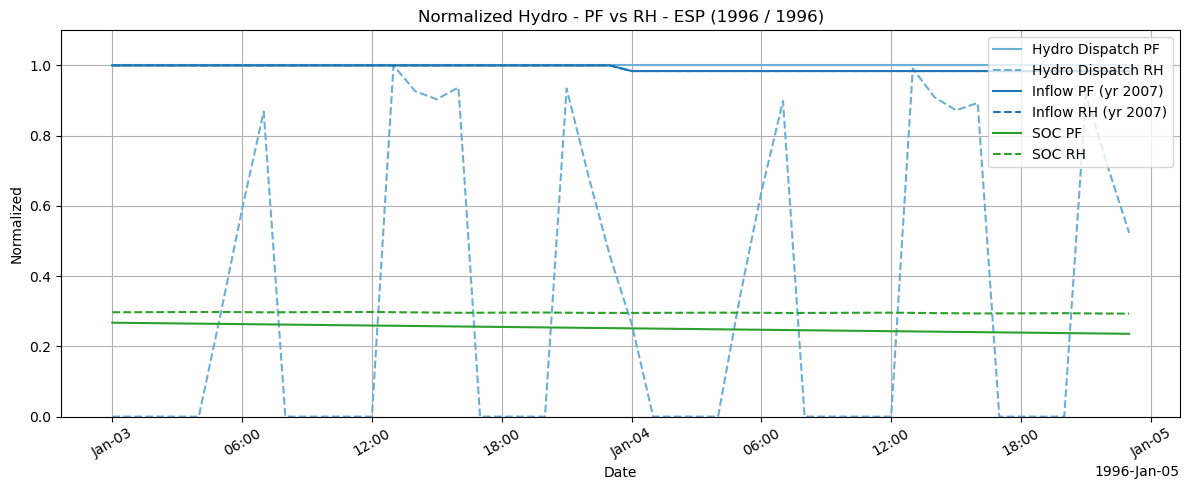

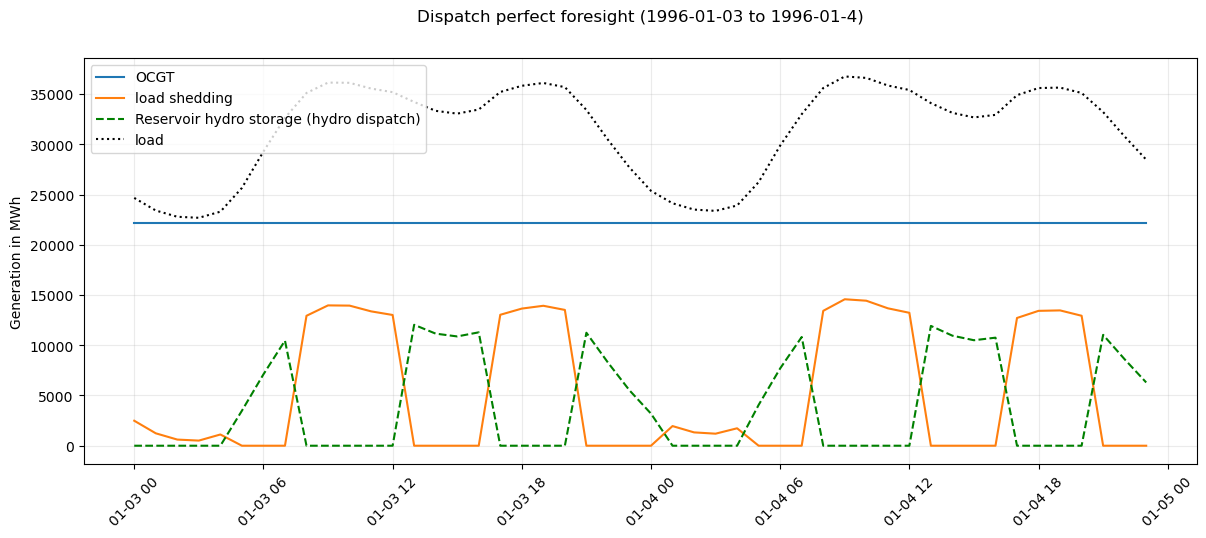

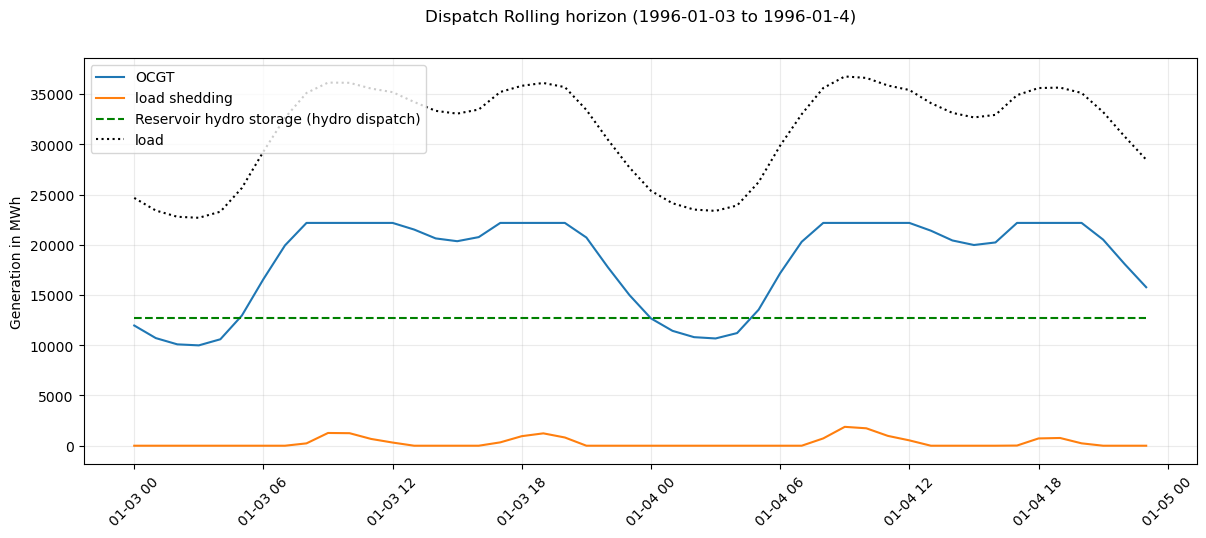

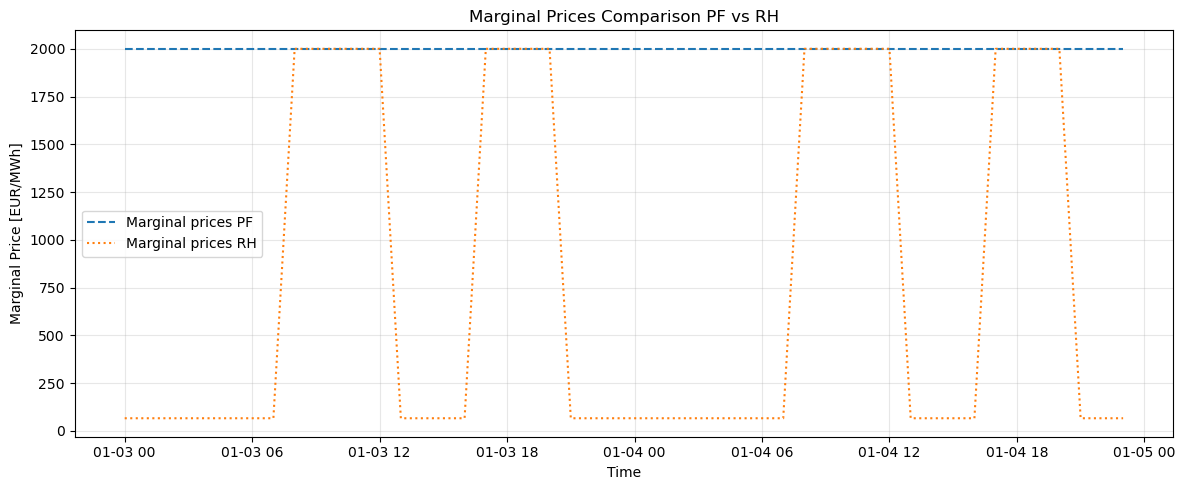

Sum of marginal prices (PF): 96000.0
Sum of marginal prices (RH): 37962.7
Total cost (PF) [MEUR]: 473206.17
Total cost (RH) [MEUR]: 432173.76
Total cost difference PF minus RH [MEUR]: -41032.41


In [76]:
intervall = (f"{test_year}-01-03", f"{test_year}-01-4")
plot_hydro(N_rlh, N_pf, same_axes=True, show_soc=True, show_dispatch=True, 
        show_inflow = True, normalized = True, interval=intervall)
plot_dispatch(N_pf, interval=intervall, save_plots=False,
               title=f"Dispatch perfect foresight ({intervall[0]} to {intervall[1]})")
plot_dispatch(N_rlh, interval=intervall, save_plots=False,
               title=f"Dispatch Rolling horizon ({intervall[0]} to {intervall[1]})")
# Plot marginal prices and print cost comparison
plot_marginal_prices(N_pf, N_rlh, interval=intervall)


In [77]:
# To check wether there is minimal gas dispatch in the off hours
s = slice(*intervall) if intervall is not None else slice(None)
gas = N_pf.generators.index[N_pf.generators["carrier"] == "gas"]
dispatch_by_gas_ex3 = {g: N_pf.generators_t.p[g].loc[s] for g in gas if g in N_pf.generators_t.p}
dispatch_by_gas_ex3

{'OCGT': snapshot
 1996-01-03 00:00:00    22179.637554
 1996-01-03 01:00:00    22179.637554
 1996-01-03 02:00:00    22179.637554
 1996-01-03 03:00:00    22179.637554
 1996-01-03 04:00:00    22179.637554
 1996-01-03 05:00:00    22179.637554
 1996-01-03 06:00:00    22179.637554
 1996-01-03 07:00:00    22179.637554
 1996-01-03 08:00:00    22179.637554
 1996-01-03 09:00:00    22179.637554
 1996-01-03 10:00:00    22179.637554
 1996-01-03 11:00:00    22179.637554
 1996-01-03 12:00:00    22179.637554
 1996-01-03 13:00:00    22179.637554
 1996-01-03 14:00:00    22179.637554
 1996-01-03 15:00:00    22179.637554
 1996-01-03 16:00:00    22179.637554
 1996-01-03 17:00:00    22179.637554
 1996-01-03 18:00:00    22179.637554
 1996-01-03 19:00:00    22179.637554
 1996-01-03 20:00:00    22179.637554
 1996-01-03 21:00:00    22179.637554
 1996-01-03 22:00:00    22179.637554
 1996-01-03 23:00:00    22179.637554
 1996-01-04 00:00:00    22179.637554
 1996-01-04 01:00:00    22179.637554
 1996-01-04 02:00:00

In [78]:
# To check wether there is minimal load shedding dispatch in the off hours
s = slice(*intervall) if intervall is not None else slice(None)
gas = N_pf.generators.index[N_pf.generators["carrier"] == "load shedding"]
dispatch_by_LS_ex3 = {g: N_pf.generators_t.p[g].loc[s] for g in gas if g in N_pf.generators_t.p}
dispatch_by_LS_ex3

{'load shedding': snapshot
 1996-01-03 00:00:00     2487.362446
 1996-01-03 01:00:00     1235.362446
 1996-01-03 02:00:00      611.362446
 1996-01-03 03:00:00      510.362446
 1996-01-03 04:00:00     1118.362446
 1996-01-03 05:00:00        0.000000
 1996-01-03 06:00:00        0.000000
 1996-01-03 07:00:00        0.000000
 1996-01-03 08:00:00    12934.362446
 1996-01-03 09:00:00    13969.362446
 1996-01-03 10:00:00    13947.362446
 1996-01-03 11:00:00    13375.362446
 1996-01-03 12:00:00    13015.362446
 1996-01-03 13:00:00        0.000000
 1996-01-03 14:00:00        0.000000
 1996-01-03 15:00:00        0.000000
 1996-01-03 16:00:00        0.000000
 1996-01-03 17:00:00    13034.362446
 1996-01-03 18:00:00    13651.362446
 1996-01-03 19:00:00    13931.362446
 1996-01-03 20:00:00    13519.362446
 1996-01-03 21:00:00        0.000000
 1996-01-03 22:00:00        0.000000
 1996-01-03 23:00:00        0.000000
 1996-01-04 00:00:00        0.000000
 1996-01-04 01:00:00     1956.362446
 1996-01-04